In [1]:
# load modules
# import numpy as np
from os.path import join

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
from tqdm import tqdm, tqdm_notebook

In [2]:
# load data
data_dir = '../../data/'
chat_path = join(data_dir, 'chat.parquet')
ban_actions_path = join(data_dir, 'banActions.parquet')
delete_actions_path = join(data_dir, 'deleteActions.parquet')

chat_df = pd.read_parquet(chat_path)
ban_df = pd.read_parquet(ban_actions_path)
delete_actions_df = pd.read_parquet(delete_actions_path)

In [3]:
chat_df.info()

print(f"# of chat: {str(len(chat_df))}")
print(f"# of banActions: {str(len(ban_df))}")
print(f"# of deleteActions: {str(len(delete_actions_df))}")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1620066 entries, 0 to 988607
Data columns (total 14 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   type             1620066 non-null  object        
 1   id               1620066 non-null  object        
 2   timestampUsec    1620066 non-null  datetime64[ns]
 3   authorName       1619778 non-null  object        
 4   authorChannelId  1620066 non-null  object        
 5   authorPhoto      1620066 non-null  object        
 6   isVerified       1620066 non-null  bool          
 7   isOwner          1620066 non-null  bool          
 8   isModerator      1620066 non-null  bool          
 9   message          1618899 non-null  object        
 10  originVideoId    1318938 non-null  object        
 11  originChannelId  1318938 non-null  object        
 12  isMember         1620066 non-null  bool          
 13  isSuperchat      1620066 non-null  bool          
dtypes: 

In [4]:
# sort out spams

deletedChatIds = delete_actions_df['targetId']
chat_df.drop(chat_df[chat_df['id'].isin(deletedChatIds)].index, inplace=True)

# remove chat with empty message (mostly superchat?)
# for later processing in sentence encoding
chat_df = chat_df[chat_df['message'].notnull()]

spam_ids = ban_df["channelId"]
spam_excludes = pd.read_csv(
    join(data_dir, 'spam_exclusion.txt'), header=None,
    squeeze=True)  # manually exclude wrongly flagged users
spam_ids = spam_ids[~spam_ids.isin(spam_excludes)]

chat_df['spam'] = chat_df['authorChannelId'].isin(spam_ids)

markedAsSpam = chat_df[chat_df["spam"]]
harmless = chat_df[~chat_df["spam"]]
print(f'# of spam: {str(len(markedAsSpam))}')
print(f'# of not spam: {str(len(harmless))}')
print("spam ratio: ", len(markedAsSpam) / len(harmless))

markedAsSpam = markedAsSpam.sort_values('authorName')

target_col = ["authorName", "authorChannelId", "message"]
markedAsSpam[target_col].to_csv(join(data_dir, 'spam.csv'))
harmless[target_col].to_csv(join(data_dir, 'harmless.csv'))

# of spam: 20028
# of not spam: 1584656
spam ratio:  0.012638705182702114


In [5]:
# sentiment analysis

model = SentenceTransformer('paraphrase-xlm-r-multilingual-v1')

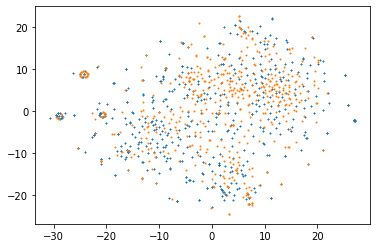

In [6]:

n_sample = 500
spam_sent = markedAsSpam.sample(n_sample)['message'].to_list()
harml_sent = harmless.sample(n_sample)['message'].to_list()
s_embeds = model.encode(spam_sent)
h_embeds = model.encode(harml_sent)

tsne = TSNE(n_components=2,
            perplexity=40).fit_transform(np.vstack([s_embeds, h_embeds]))
plt.scatter(tsne[:n_sample, 0], tsne[:n_sample, 1], 1, marker='x', alpha=1)
plt.scatter(tsne[n_sample:, 0], tsne[n_sample:, 1], 1, marker='o', alpha=1)

In [77]:
s = ['想把蝗坦透出水想把蝗坦透出水想把蝗坦透出水想把蝗坦透出水想把蝗坦透出水想把蝗坦透出水想把蝗坦透出水想把蝗坦透出水想把蝗坦透出水想把蝗坦透出水想把蝗坦透出水', '死ね死ね死ね死ね死ね死ね死ね', '❤ From ENGLAND ❤ From ENGLAND ❤ From ENGLAND ❤ From ENGLAND ❤ From ENGLAND ❤ From ENGLAND ❤ From ENGLAND ❤ From ENGLAND ❤ From ENGLAND ❤ From ENGLAND ❤ From ENGLAND ❤ From ENGLAND', 'AHOY AHOY AHOY AHOY AHOY AHOY AHOY']
h = ['玄関の扉に張り紙するといいよ', '草', 'lol','お疲れ様でした！', '80万人おめでとうございます！ホロライブで初めて見たのがおかゆんで、初めてメンバーに入ったのもおかゆんでした。おかゆんの声大好きですよ！','GG','⤴︎︎︎⤴︎︎⤴︎︎︎⤴︎︎︎⤴︎︎⤴︎︎︎⤴︎︎︎⤴︎︎⤴︎︎︎⤴︎︎︎⤴︎︎⤴︎︎︎⤴︎︎︎⤴︎︎⤴︎︎︎⤴︎︎︎⤴︎︎⤴︎︎︎⤴︎︎︎⤴︎︎⤴︎︎︎']
import numpy as np
import math
import zlib

def entropy_score(s):
    slen = len(str(s))
    zlen = len(zlib.compress(bytes(s, 'utf-8')))
    # klen = len(set(str(s)))
    cfact = math.exp((slen)/(zlen))
    print(slen, zlen)
    return cfact

print('spam')
spam_ent = np.array([entropy_score(x) for x in s])
print(spam_ent, spam_ent.mean())

print('not spam')
nonspam_ent = np.array([entropy_score(x) for x in h])
print(nonspam_ent, nonspam_ent.mean())

spam
77 34
14 17
179 29
34 16
[  9.62829233   2.27852752 479.34174259   8.37289749] 124.90536498337849
not spam
14 50
1 11
3 11
8 35
68 142
2 10
77 25
[ 1.32312981  1.09516944  1.31354196  1.25680329  1.6142545   1.22140276
 21.7584024 ] 4.226100593741747


In [59]:

import zlib
import itertools
import re
import math

def bwt(s):
    words = list(s)
    tgt = []
    for i in range(len(words)):
        word = s[-1] + s[:-1]
        new = ''.join(word)
        s = new
        tgt.append(new)
        i += 1
    sort = sorted(tgt)
    bwt = []
    for i in range(len(words)):
        element = sort[i]
        last = element[- 1]
        i = i + 1
        bwt.append(last)
    return ''.join(bwt)


def bwt_rl_entropy(s):
    # s = re.sub(r"\s", '', s)
    slen = len(s)
    bwt_rl_len = len([ch for ch, _ in itertools.groupby(bwt(s))])
    return slen/bwt_rl_len


def accum_entropy(arr):
    full = ''.join(arr)
    print('\n','\n'.join(arr))
    f_score = bwt_rl_entropy(full)
    return math.exp(f_score)

spammer = ['想把蝗坦透出水想把蝗坦透出水想把蝗坦透出水想把蝗坦透出水想把蝗坦透出水想把蝗坦透出水想把蝗坦透出水想把蝗坦透出水想把蝗坦透出水想把蝗坦透出水想把蝗坦透出水','想把蝗坦透出水想把蝗坦透出水', '想把蝗坦透出水', '樹皮~']
print(accum_entropy(spammer))

spammer2 = ['say baw pls bark', 'bark', 'bark i clip', 'bark', 'bark', 'bark']
print(accum_entropy(spammer2))

spammer3 = ['say baw pls bark', 'bark', 'bark i clip', 'bark', 'bark', 'bark', 'bark', 'bark']
print(accum_entropy(spammer3))

non_spammer = ['lol', 'why', 'lets goooooo', 'nice', 'lol', 'lol']
print(accum_entropy(non_spammer))

non_spammer2 = ['こわい', 'おはようございます', 'すいちゃん今日もかわいい！！！！！', 'あっ', 'イジられてるの', 'サイコ…']
print(accum_entropy(non_spammer2))

non_spammer3 = ['ナイス！', 'ナイス！']
print(accum_entropy(non_spammer3))


 想把蝗坦透出水想把蝗坦透出水想把蝗坦透出水想把蝗坦透出水想把蝗坦透出水想把蝗坦透出水想把蝗坦透出水想把蝗坦透出水想把蝗坦透出水想把蝗坦透出水想把蝗坦透出水
想把蝗坦透出水想把蝗坦透出水
想把蝗坦透出水
樹皮~
9718.8072771995

 say baw pls bark
bark
bark i clip
bark
bark
bark
7.060708881050856

 say baw pls bark
bark
bark i clip
bark
bark
bark
bark
bark
10.157189889169787

 lol
why
lets goooooo
nice
lol
lol
4.365288192202982

 こわい
おはようございます
すいちゃん今日もかわいい！！！！！
あっ
イジられてるの
サイコ…
3.0200191061144728

 ナイス！
ナイス！
7.38905609893065
